# 「日本で最も丸い湖」を探す 💧👌 - 最急降下法による探索


In [1]:
import math
import shutil
import os
from pathlib import Path

import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from tqdm.notebook import tqdm

In [2]:
OUTPUT_DIR_ROOT = Path("output")
OUTPUT_FINAL_DIR = OUTPUT_DIR_ROOT / "final"
OUTPUT_TRIALS_DIR_ROOT = OUTPUT_DIR_ROOT / "trials"

## データ

`japan.ipynb` で用意したもの:


In [3]:
gdf = gpd.read_file("japan.geojson")
gdf

,湖沼名,行政区域コード,最大水深,水面標高,都道府県,周囲長,面積,円形度,geometry
0,さっぽろ湖,01100,None,None,北海道,17266.599491,1.784306e+06,0.075208,"POLYGON ((1001989.090 4778014.420, 1001986.243..."
1,定山湖,01100,None,None,北海道,12675.560584,1.415566e+06,0.110715,"POLYGON ((1001796.797 4768236.691, 1001796.494..."
2,オタルナイ湖,01203,None,None,北海道,3098.593932,2.998003e+05,0.392385,"POLYGON ((991624.057 4793407.236, 991626.680 4..."
3,春採湖,01206,None,None,北海道,4510.042551,3.485092e+05,0.215309,"POLYGON ((1267613.496 4801427.797, 1267613.309..."
4,富里湖,01208,None,None,北海道,3253.300842,1.978890e+05,0.234954,"POLYGON ((1202955.207 4893685.089, 1202959.210..."
...,...,...,...,...,...,...,...,...,...
551,フンガー湖,47301,None,None,沖縄県,6839.734068,1.368298e+05,0.036755,"POLYGON ((-169172.846 2976897.207, -169177.757..."
552,伊集の湖,47301,None,None,沖縄県,13876.185298,2.817393e+05,0.018387,"POLYGON ((-170469.119 2981102.327, -170467.123..."
553,福上湖,47303,None,None,沖縄県,46528.487906,2.214969e+06,0.012857,"POLYGON ((-174919.821 2966740.620, -174915.221..."
554,新川湖,47303,None,None,沖縄県,5343.803670,1.066351e+05,0.046926,"POLYGON ((-173601.971 2970251.071, -173595.623..."


## 関数


In [4]:
def plot_geoms(lake, circle, score, set_lims=False):
    """
    湖と円を重ね合わせてプロット、スコアも表示
    """
    ax = gpd.gpd.GeoSeries([lake, circle]).plot(color=["#1e40af", "#e11d4899"])

    ax.set_axis_off()

    if set_lims:
        # 半径＝「バウンディングボックスの対角線の長さの1/2」の円が収まる範囲
        x_min, y_min, x_max, y_max = lake.bounds
        center = [(x_min + x_max) / 2, (y_min + y_max) / 2]
        radius = math.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2) / 2
        ax.set_xlim(center[0] - radius, center[0] + radius)
        ax.set_ylim(center[1] - radius, center[1] + radius)

    fig = ax.figure
    caption = f"{score:.3f}"
    text = plt.figtext(
        0.5,
        0.5,
        caption,
        wrap=True,
        ha="center",
        va="center",
        fontsize=32,
        color="#1e293b",
    )
    text.set_path_effects(
        [path_effects.withStroke(linewidth=2, foreground="#ffffff44")]
    )

    return fig

In [5]:
def calculate_score(lake, circle):
    """
    湖と円の重なり面積の割合
    """
    area_intersection = lake.intersection(circle).area
    area_denominator = max(lake.area, circle.area)
    return area_intersection / area_denominator

In [6]:
def neighbors(center, radius, delta_perc=0.005):
    """
    円を、上下左右に移動させたり、半径を大きくしたり小さくしたりする
    """
    delta = radius * delta_perc
    delta_options = [-delta * 20, -delta, 0, delta, delta * 20]

    for cx_delta in delta_options:
        for cy_delta in delta_options:
            for r_delta in delta_options:
                yield ((center[0] + cx_delta, center[1] + cy_delta), radius + r_delta)

In [7]:
def get_initial_circle_params(lake):
    """
    探索の初期値

    中心: バウンディングボックスの中心
    半径: バウンディングボックスの対角線の長さの1/2
    """
    x_min, y_min, x_max, y_max = lake.bounds
    center = [(x_min + x_max) / 2, (y_min + y_max) / 2]

    radius = math.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2) / 2

    return center, radius

In [8]:
N_ITERATIONS = 300


def optimize_circle_score(
    geometry,
    name,
    output_final=True,
    output_trials=False,
):
    if output_trials:
        output_trials_dir = OUTPUT_TRIALS_DIR_ROOT / name
        shutil.rmtree(output_trials_dir, ignore_errors=True)
        os.makedirs(output_trials_dir)

    curr_center, curr_radius = get_initial_circle_params(geometry)
    circle = shapely.geometry.Point(curr_center).buffer(curr_radius)
    curr_score = calculate_score(geometry, circle)

    trial_count = 1
    iter_score = curr_score
    converged = False

    for iter_count in range(1, N_ITERATIONS + 1):
        for nb_center, nb_radius in neighbors(curr_center, curr_radius):
            trial_count += 1

            nb_circle = shapely.geometry.Point(nb_center).buffer(nb_radius)
            nb_score = calculate_score(geometry, nb_circle)

            if nb_score > curr_score:
                curr_score = nb_score
                curr_center = nb_center
                curr_radius = nb_radius
                if output_trials:
                    fig = plot_geoms(geometry, nb_circle, nb_score, set_lims=True)
                    fig.savefig(
                        output_trials_dir / f"{trial_count:04d}.png",
                        bbox_inches="tight",
                    )
                    plt.close()

        if curr_score > iter_score:
            iter_score = curr_score
        else:
            converged = True
            break

    best_circle = shapely.geometry.Point(curr_center).buffer(curr_radius)
    best_score = calculate_score(geometry, best_circle)

    if output_final:
        fig = plot_geoms(geometry, best_circle, best_score)
        fig.savefig(OUTPUT_FINAL_DIR / f"{name}.png", bbox_inches="tight")
        plt.close()

    converged_iter_count = iter_count if converged else None
    return best_circle, best_score, converged_iter_count

### 確認


13


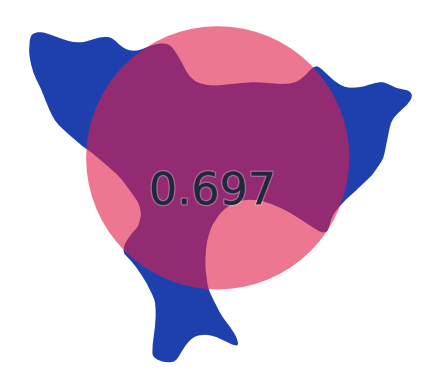

In [9]:
test_index = 100

test_row = gdf.iloc[test_index]
test_name = f"{test_index:03d}_{test_row['湖沼名']}"

best_circle, best_score, converged_iter_count = optimize_circle_score(
    test_row.geometry,
    test_name,
    output_final=False,
    output_trials=True,
)

print(converged_iter_count)
fig = plot_geoms(test_row.geometry, best_circle, best_score)

21


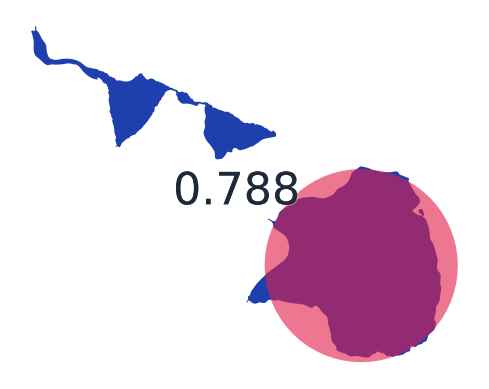

In [10]:
test_index = 18

test_row = gdf.iloc[test_index]
test_name = f"{test_index:03d}_{test_row['湖沼名']}"

best_circle, best_score, converged_iter_count = optimize_circle_score(
    test_row.geometry,
    test_name,
    output_final=False,
    output_trials=True,
)

print(converged_iter_count)
fig = plot_geoms(test_row.geometry, best_circle, best_score)

28


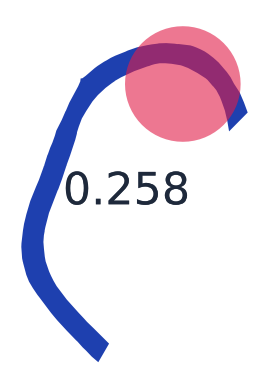

In [11]:
test_index = 30

test_row = gdf.iloc[test_index]
test_name = f"{test_index:03d}_{test_row['湖沼名']}"

best_circle, best_score, converged_iter_count = optimize_circle_score(
    test_row.geometry,
    test_name,
    output_final=False,
    output_trials=True,
)

print(converged_iter_count)
fig = plot_geoms(test_row.geometry, best_circle, best_score)

20


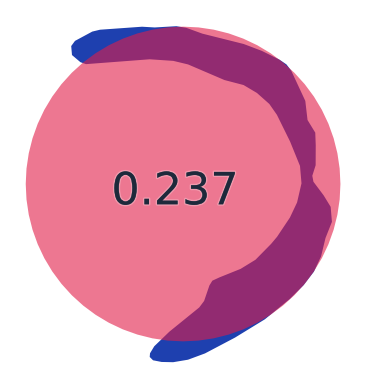

In [12]:
test_index = 50

test_row = gdf.iloc[test_index]
test_name = f"{test_index:03d}_{test_row['湖沼名']}"

best_circle, best_score, converged_iter_count = optimize_circle_score(
    test_row.geometry,
    test_name,
    output_final=False,
    output_trials=True,
)

print(converged_iter_count)
fig = plot_geoms(test_row.geometry, best_circle, best_score)

21


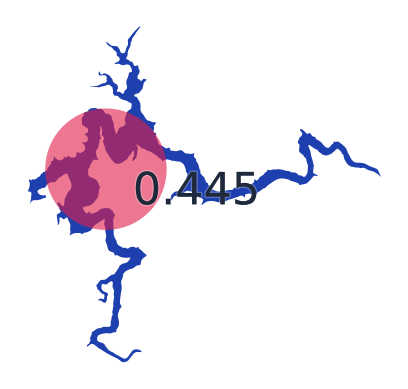

In [13]:
test_index = 492

test_row = gdf.iloc[test_index]
test_name = f"{test_index:03d}_{test_row['湖沼名']}"

best_circle, best_score, converged_iter_count = optimize_circle_score(
    test_row.geometry,
    test_name,
    output_final=False,
    output_trials=True,
)

print(converged_iter_count)
fig = plot_geoms(test_row.geometry, best_circle, best_score)

26


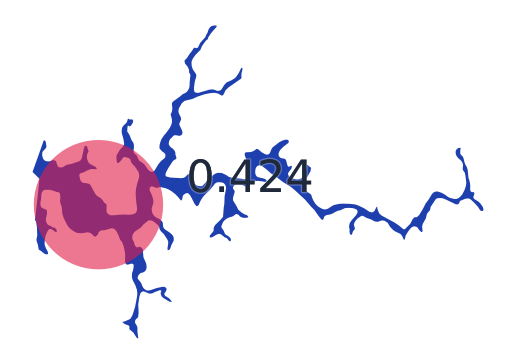

In [14]:
test_index = 552

test_row = gdf.iloc[test_index]
test_name = f"{test_index:03d}_{test_row['湖沼名']}"

best_circle, best_score, converged_iter_count = optimize_circle_score(
    test_row.geometry,
    test_name,
    output_final=False,
    output_trials=True,
)

print(converged_iter_count)
fig = plot_geoms(test_row.geometry, best_circle, best_score)

## 探索


In [15]:
shutil.rmtree(OUTPUT_FINAL_DIR, ignore_errors=True)
os.makedirs(OUTPUT_FINAL_DIR)

In [16]:
results = []

for gdf_index, row in tqdm(gdf.iterrows(), total=len(gdf)):
    name = f"{gdf_index:03d}_{row['湖沼名']}"
    geometry = row.geometry

    best_circle, best_score, converged_iter_count = optimize_circle_score(
        geometry, name
    )
    results.append((best_circle, best_score, converged_iter_count))

    if converged_iter_count is None:
        print(f"DID NOT CONVERGE: {name}")

  0%|          | 0/556 [00:00<?, ?it/s]

## 集約


In [17]:
df_results = pd.DataFrame(
    results,
    columns=["circle", "score", "converged_iter_count"],
)
df_results

gdf_after = gpd.GeoDataFrame(
    pd.concat([gdf, df_results], axis=1),
)
gdf_after

,湖沼名,行政区域コード,最大水深,水面標高,都道府県,周囲長,面積,円形度,geometry,circle,score,converged_iter_count
0,さっぽろ湖,01100,None,None,北海道,17266.599491,1.784306e+06,0.075208,"POLYGON ((1001989.090 4778014.420, 1001986.243...","POLYGON ((1002553.893386327 4778316.731001287,...",0.424011,26
1,定山湖,01100,None,None,北海道,12675.560584,1.415566e+06,0.110715,"POLYGON ((1001796.797 4768236.691, 1001796.494...",POLYGON ((1002736.3825765701 4768932.488484370...,0.486918,18
2,オタルナイ湖,01203,None,None,北海道,3098.593932,2.998003e+05,0.392385,"POLYGON ((991624.057 4793407.236, 991626.680 4...","POLYGON ((991801.4804250145 4793057.0945377, 9...",0.631853,16
3,春採湖,01206,None,None,北海道,4510.042551,3.485092e+05,0.215309,"POLYGON ((1267613.496 4801427.797, 1267613.309...",POLYGON ((1267697.3922237128 4801232.088652701...,0.407332,21
4,富里湖,01208,None,None,北海道,3253.300842,1.978890e+05,0.234954,"POLYGON ((1202955.207 4893685.089, 1202959.210...",POLYGON ((1203375.1321618373 4893454.318622537...,0.477688,22
...,...,...,...,...,...,...,...,...,...,...,...,...
551,フンガー湖,47301,None,None,沖縄県,6839.734068,1.368298e+05,0.036755,"POLYGON ((-169172.846 2976897.207, -169177.757...",POLYGON ((-168957.71792216858 2976105.00861053...,0.442837,28
552,伊集の湖,47301,None,None,沖縄県,13876.185298,2.817393e+05,0.018387,"POLYGON ((-170469.119 2981102.327, -170467.123...",POLYGON ((-170589.41536030226 2980561.71592602...,0.424126,26
553,福上湖,47303,None,None,沖縄県,46528.487906,2.214969e+06,0.012857,"POLYGON ((-174919.821 2966740.620, -174915.221...",POLYGON ((-177908.46704523862 2965719.31183752...,0.296867,28
554,新川湖,47303,None,None,沖縄県,5343.803670,1.066351e+05,0.046926,"POLYGON ((-173601.971 2970251.071, -173595.623...",POLYGON ((-172894.94152451877 2969101.56481611...,0.387968,31


## 結果


### 収束にかかったイテレーション数


In [18]:
gdf_after.converged_iter_count.describe()

count    556.000000
mean      19.158273
std        5.249809
min        7.000000
25%       16.000000
50%       19.000000
75%       23.000000
max       36.000000
Name: converged_iter_count, dtype: float64

<Axes: >

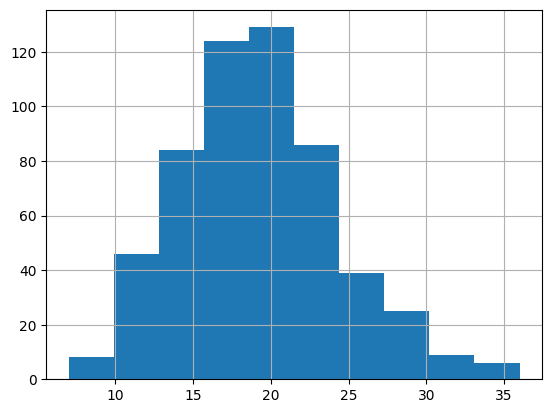

In [19]:
gdf_after.converged_iter_count.hist()

In [20]:
gdf_after.sort_values("converged_iter_count", ascending=False).head(10)

,湖沼名,行政区域コード,最大水深,水面標高,都道府県,周囲長,面積,円形度,geometry,circle,score,converged_iter_count
442,富栖湖,28522,None,None,兵庫県,3223.908282,8.928044e+04,0.107945,"POLYGON ((464916.205 3878214.560, 464916.788 3...",POLYGON ((464962.8899043882 3878222.0038809665...,0.451843,36
323,琅鶴湖,"20201,20581",None,None,長野県,13137.053435,7.291244e+05,0.053090,"POLYGON ((772550.120 4051868.922, 772545.655 4...",POLYGON ((770300.0543602309 4051363.1222945508...,0.249896,35
413,七色貯水池,"24212,29450,30427",None,None,和歌山県/三重県/奈良県,21984.311328,1.431368e+06,0.037216,"POLYGON ((592450.407 3761902.784, 592429.603 3...","POLYGON ((594162.8999683885 3759723.133316919,...",0.205602,35
150,田瀬湖,03361,0,195,岩手県,26494.481943,2.846048e+06,0.050950,"POLYGON ((1044211.842 4373396.351, 1044204.794...",POLYGON ((1045587.0724317691 4371837.355529013...,0.291382,35
401,佐久間湖,"22487,22488,23563,23564",None,None,静岡県/愛知県,47891.461369,4.607050e+06,0.025242,"POLYGON ((756544.012 3897791.671, 756530.156 3...","POLYGON ((756317.5125526226 3890765.407922317,...",0.289136,34
538,野尻湖,"45345,45361,45362",0,130,宮崎県,57759.890301,1.982224e+06,0.007466,"POLYGON ((132801.338 3542378.095, 132787.526 3...",POLYGON ((132727.17672730036 3539812.150301305...,0.313672,34
41,朱鞠内湖（宇津内湖）,01439,0,280,北海道,15026.331016,1.495055e+06,0.083207,"POLYGON ((1070016.188 4932992.464, 1070006.306...",POLYGON ((1070982.6773834184 4933373.848958957...,0.585690,33
292,内川湖,17201,0,240,石川県,6998.387380,2.802260e+05,0.071899,"POLYGON ((649370.183 4037577.939, 649368.185 4...","POLYGON ((649713.6139980736 4037242.529729701,...",0.399057,33
475,白竜湖,"34204,34212",None,None,広島県,8993.669991,5.530454e+05,0.085920,"POLYGON ((308553.337 3820236.579, 308575.644 3...","POLYGON ((307132.989553294 3820107.8225838267,...",0.477106,33
384,白水湖,21604,None,None,岐阜県,5796.029923,6.271177e+05,0.234584,"POLYGON ((663986.503 4001515.635, 663987.717 4...","POLYGON ((664038.050709521 4000750.041689887, ...",0.550361,33


### スコア: 上位


In [21]:
gdf_after.sort_values("score", ascending=False).head(10)[
    ["湖沼名", "円形度", "score", "面積", "周囲長"]
]

,湖沼名,円形度,score,面積,周囲長
69,倶多楽湖,0.945450,0.978189,4.712454e+06,7914.240329
170,田沢湖,0.774597,0.942992,2.587661e+07,20489.001974
362,巣鷹湖,0.902002,0.934657,2.880701e+04,633.505109
175,明月湖,0.954554,0.922572,9.776947e+02,113.450498
309,南伊奈ヶ湖,0.876669,0.920240,1.380765e+04,444.884269
547,鰻池,0.859650,0.919152,1.206303e+06,4199.256155
80,東雲湖（東小沼）,0.920083,0.919140,4.838713e+04,812.935835
51,パンケ沼,0.735632,0.909968,3.566827e+06,7805.769471
118,宇曽利山湖,0.664897,0.907230,2.690288e+06,7130.617201
545,池田湖,0.609720,0.900582,1.095369e+07,15025.180475


In [22]:
gdf_after.sort_values("円形度", ascending=False).head(10)[
    ["湖沼名", "円形度", "score", "面積", "周囲長"]
]

,湖沼名,円形度,score,面積,周囲長
175,明月湖,0.954554,0.922572,9.776947e+02,113.450498
69,倶多楽湖,0.945450,0.978189,4.712454e+06,7914.240329
80,東雲湖（東小沼）,0.920083,0.919140,4.838713e+04,812.935835
314,四尾連湖,0.907386,0.883946,6.753465e+04,967.101981
362,巣鷹湖,0.902002,0.934657,2.880701e+04,633.505109
309,南伊奈ヶ湖,0.876669,0.920240,1.380765e+04,444.884269
547,鰻池,0.859650,0.919152,1.206303e+06,4199.256155
26,橘湖,0.857549,0.842274,9.561053e+04,1183.663517
147,御釜湖,0.812825,0.799618,1.825635e+03,168.001543
146,昭和湖,0.808037,0.882452,2.427759e+03,194.308592


### スコア: 下位


In [23]:
gdf_after.sort_values("score", ascending=True).head(10)[
    ["湖沼名", "円形度", "score", "面積", "周囲長"]
]

,湖沼名,円形度,score,面積,周囲長
151,錦秋湖,0.045355,0.084472,3.935990e+06,33023.337876
432,神戸水道千刈水源池,0.045364,0.157372,9.293488e+05,16044.943149
413,七色貯水池,0.037216,0.205602,1.431368e+06,21984.311328
375,丸山蘇水湖,0.033732,0.233319,1.301878e+06,22022.772608
50,犬吼湖,0.184268,0.236854,2.275186e+04,1245.627292
541,塚原ダム貯水池,0.050804,0.244227,9.631727e+05,15435.007723
427,虹の湖,0.022528,0.247117,1.083538e+06,24584.691031
323,琅鶴湖,0.053090,0.249896,7.291244e+05,13137.053435
488,小野湖,0.036002,0.257048,1.554353e+06,23292.466607
30,しのつ湖,0.120419,0.258447,3.135862e+05,5720.526044


In [24]:
gdf_after.sort_values("円形度", ascending=True).head(10)[
    ["湖沼名", "円形度", "score", "面積", "周囲長"]
]

,湖沼名,円形度,score,面積,周囲長
538,野尻湖,0.007466,0.313672,1.982224e+06,57759.890301
553,福上湖,0.012857,0.296867,2.214969e+06,46528.487906
206,菅生沼,0.015008,0.499505,5.335258e+05,21136.182357
42,朱鞠内湖,0.018236,0.707127,2.189462e+07,122831.775969
552,伊集の湖,0.018387,0.424126,2.817393e+05,13876.185298
446,津風呂湖,0.018963,0.397815,1.058867e+06,26489.190921
537,一ツ瀬ダム貯水池,0.018993,0.358474,4.444853e+06,54229.982980
192,奥只見湖,0.019096,0.438290,1.050267e+07,83135.189283
193,田子倉湖,0.019678,0.448492,1.031421e+07,81157.684358
300,九頭竜湖,0.021202,0.318028,7.362565e+06,66058.424862


## ドキュメント


In [25]:
with open("results.md", "w") as fp:
    for rank, (index, row) in enumerate(
        gdf_after.sort_values("score", ascending=False).iterrows(), start=1
    ):
        name = row["湖沼名"]
        fpath = OUTPUT_FINAL_DIR / f"{index:03d}_{row['湖沼名']}.png"
        score = row["score"]
        area = row["面積"]  # m2
        perimeter = row["周囲長"]  # m
        circularity = row["円形度"]
        converged_iter_count = row["converged_iter_count"]
        pref = row["都道府県"]

        print(f"## {rank}. {name} （{pref}）", file=fp)
        print(file=fp)
        print(
            f"- スコア: {score:.5f} （{converged_iter_count:.0f} iterations）", file=fp
        )
        print(f"- 円形度: {circularity:.5f}", file=fp)

        if (area / 1000 / 1000) >= 1:
            area /= 1000 * 1000
            unit = "km&sup2;"
        else:
            unit = "m&sup2;"
        print(f"- 面積: {area:,.0f}{unit}", end="", file=fp)

        if perimeter >= 1000:
            perimeter /= 1000
            unit = "km"
        else:
            unit = "m"
        print(f", 周囲長: {perimeter:,.0f}{unit}", file=fp)

        print(file=fp)
        print(f"![{name}]({fpath})", file=fp)
        print(file=fp)